In [1]:
## GaS Simulation
import abtem
import ase.io
import matplotlib.pyplot as plt
import numpy as np
import py4DSTEM
from ase.io import read
from ase.build import surface
from abtem.atoms import pretty_print_transform



# Custom functions used in this script
from FunctionPackageOM.Plot_Style import Plot_Style_OM_activate

# Load custom plot style
Plot_Style_OM_activate(white_bkg_for_visualization=True)


# Uncomment if running in Jupyter
%matplotlib ipympl

cupyx.jit.rawkernel is experimental. The interface can change in the future.


## Settings for GPU vs CPU

In [2]:
# data stored in the config
abtem.config.config

{'device': 'cpu',
 'fft': 'fftw',
 'precision': 'float32',
 'diagnostics': {'progress_bar': True, 'task_progress': False},
 'dask': {'lazy': True, 'chunk-size': '128 MB', 'chunk-size-gpu': '512 MB'},
 'cupy': {'fft-cache-size': '0 MB'},
 'mkl': {'threads': 2},
 'fftw': {'threads': 1,
  'planning_effort': 'FFTW_MEASURE',
  'planning_timelimit': 60,
  'allow_fallback': True},
 'warnings': {'dask-blockwise-performance': False, 'overspecified-grid': True},
 'antialias': {'cutoff': 0.6666666, 'taper': 0.01},
 'visualize': {'real_space_units': 'Angstrom',
  'reciprocal_space_units': 'Angstrom',
  'cmap': 'viridis',
  'phase_cmap': 'hsluv',
  'continuous_update': False,
  'autoscale': False,
  'use_tex': True}}

In [3]:
## set to gpu or cpu
# abtem.config.set({"device": "cpu"})
abtem.config.set({"device": "gpu"})

Text(0.5, 0.98, 'GaS_on_sapphire full structure')

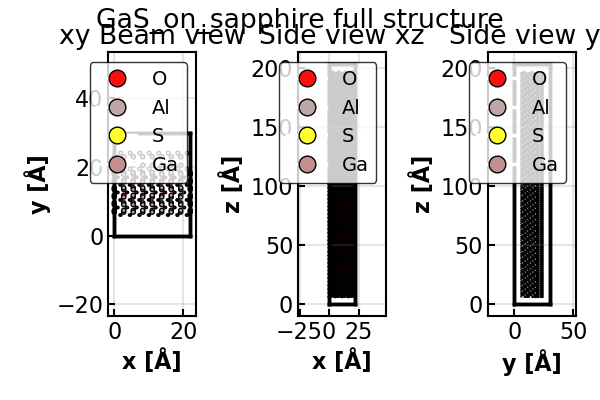

In [4]:
## load simulation file

GaS_on_sapphire = ase.io.read('/masc_shared/ag_volz/Oliver_Maßmeyer/TEM_Simulations/GaS_on_Sapphire_cross_section/CIF_Files/GaS_on_sapphire_optimized_GaS_cut_angstrom.xyz')
#check cell
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(6, 4))
abtem.show_atoms(GaS_on_sapphire, ax=ax1, title="xy Beam view", show_periodic=True, scale=0.5, legend=True)
abtem.show_atoms(GaS_on_sapphire, ax=ax2, plane="xz", title="Side view xz", show_periodic=True, scale=0.5,
                 legend=True)
abtem.show_atoms(GaS_on_sapphire, ax=ax3, plane="yz", title="Side view yz", show_periodic=True, scale=0.5,
                 legend=True)
fig.tight_layout()
fig.suptitle('GaS_on_sapphire full structure')

In [5]:
## caluclate Frozen Phonons

displacements_nm = {'Ga': 7.113736674861319e-05, 'S':6.352344019765251e-05, 'Al': 2.96e-05, 'O': 3.312e-05} #  MSDs
displacements_Ang = {key:displacements_nm[key]**0.5*10 for key in displacements_nm.keys()} # conversion nm² to Ang
print(displacements_Ang) # displacments in Ang

frozen_phonons = abtem.FrozenPhonons(GaS_on_sapphire, num_configs=10, sigmas=displacements_Ang, seed=1993)
# frozen_phonons = abtem.FrozenPhonons(GaS_on_sapphire, num_configs=0, sigmas=displacements_Ang, seed=1993)

# frozen_phonons = GaS_on_sapphire


{'Ga': 0.08434297051243404, 'S': 0.07970159358359938, 'Al': 0.054405882034941774, 'O': 0.05754997827975263}


Text(0.5, 0.98, 'Current Phonon Configuration')

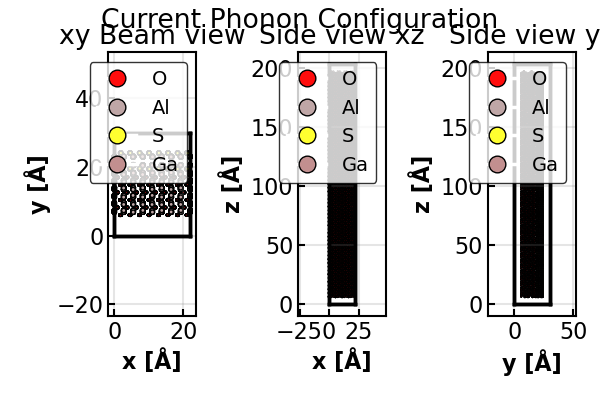

In [6]:
atoms_configuration = next(iter(frozen_phonons))
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(6, 4))
abtem.show_atoms(atoms_configuration, ax=ax1, title="xy Beam view", show_periodic=True, scale=0.5, legend=True)
abtem.show_atoms(atoms_configuration, ax=ax2, plane="xz", title="Side view xz", show_periodic=True, scale=0.5,
                 legend=True)
abtem.show_atoms(atoms_configuration, ax=ax3, plane="yz", title="Side view yz", show_periodic=True, scale=0.5,
                 legend=True)
fig.tight_layout()
fig.suptitle('Current Phonon Configuration')

Length of the Potential 171
[########################################] | 100% Completed | 11.23 s


ImageGUI(children=(VBox(children=(SelectionSlider(continuous_update=False, description='Frozen phonons', optio…

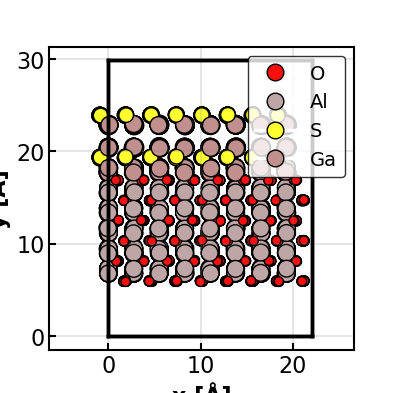

In [7]:
# run the simulation:
# abtem.config.set({"device": "gpu"})
#get slice thickness
# lengths = GaS_on_sapphire.cell.lengths()
#calculate slices:
# num_slices = 200
# slice_thicknesses = lengths[2]/num_slices # cell thickness from simulation
# print('slice_thicknesses in Angström:', slice_thicknesses)

#parameters:
energy = 200e3 # volts
semiangle_cutoff = 21 # mrad
defocus = 0 # ang

#Create the Potentials by independent atom model (IAM)
potential = abtem.Potential(
    frozen_phonons,
    sampling=0.03, # lower sampling to match 4D data // determines the max scattering angle later?
    # parametrization="lobato",
    parametrization="kirkland",
    slice_thickness=1.1889358966844914, # from construction
    projection="infinite",
)

print("Length of the Potential",len(potential))

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

atoms_configuration = next(iter(frozen_phonons))

abtem.show_atoms(atoms_configuration, legend=True)

## caluclate projected potential
potentialImage = potential.project()

potentialImage.show(interact=True,cbar=True)

# visualize the first slice
# visualization = potential[0].show(ax=ax2,cbar=True);

# # #visualize slices of the potential
# visualization = potential[0:3].show(
#     project=False,
#     explode=True,
#     figsize=(10, 2),
#     common_color_scale=True,
#     cbar=True,
#     vmin=0,
#     vmax=100,
# )

# plt.show()

defocus = 0 Å
FWHM = 0.6293559670448303 Å
[########################################] | 100% Completed | 100.86 ms
[########################################] | 100% Completed | 100.87 ms


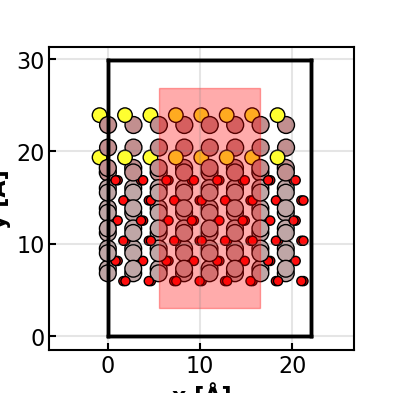

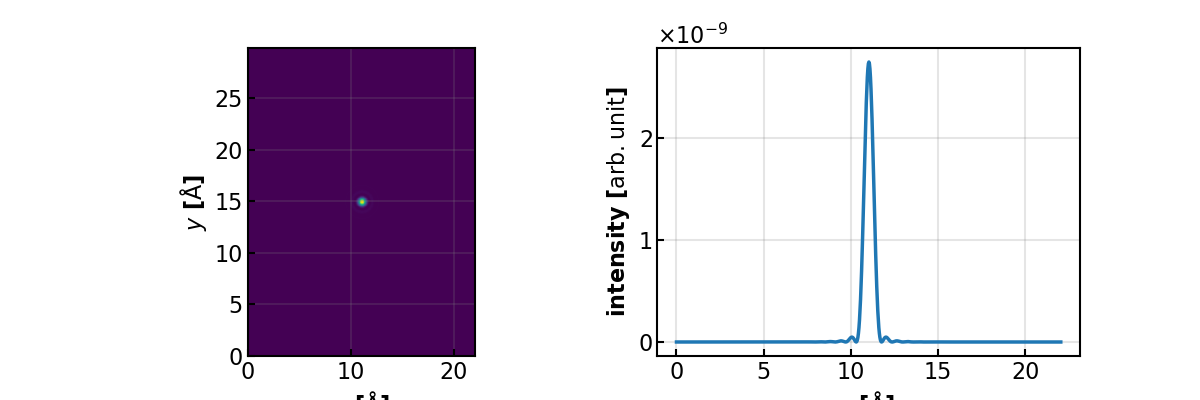

In [8]:
#create STEM Probe - 200 kV - 21 mrad Aperture, -50 um spheriacal abberation, defocus of 50 A
probe = abtem.Probe(
    energy=energy,
    semiangle_cutoff=semiangle_cutoff,
    # C10=defocus,
    C10=0, # defocus
    # Cs=-50e-6 * 1e10,
    C50=0.5e6, #5th order spherical aberration
    C30=-2.2e3, #3th order spherical aberration
)

probe.grid.match(potential)

print(f"defocus = {probe.aberrations.defocus} Å")
print(f"FWHM = {probe.profiles().width().compute()} Å")

#plot the probe profile
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
probe.show(ax=ax1)
probe.profiles().show(ax=ax2);


#apply detector settings for sampling
# num_detector_pixels = 64 # px
maximum_scattering_angle_mrad = np.max(probe.cutoff_angles) # mrad

# resample = 2*maximum_scattering_angle_mrad/num_detector_pixels

#detector
pixelated_detector = abtem.PixelatedDetector(
    # max_angle=maximum_scattering_angle_mrad*0.975,
    max_angle=maximum_scattering_angle_mrad,
    # resample=(resample,resample)
)



#setup grid scan
scan_step_size = 0.2 # ang

grid_scan = abtem.GridScan(
    sampling=scan_step_size,  
    start=[0.25, 0.1],
    end=[0.75, 0.9],

    # start=[0.4, 0.4],
    # end=[0.6, 0.6],
    fractional=True,
    potential=potential,
)

fig, ax = abtem.show_atoms(GaS_on_sapphire)
grid_scan.add_to_plot(ax)

plt.show()

In [25]:
#compute the measurement
print(
    f"Maximum simulated scattering angle = {min(probe.cutoff_angles):.1f} mrad"
)

measurements = probe.scan(potential, scan=grid_scan, detectors=pixelated_detector)
measurements.compute()
measurements.to_zarr("/masc_shared/ag_volz/Oliver_Maßmeyer/TEM_Simulations/GaS_on_Sapphire_cross_section/ABTEM/GaS_on_sapphire_200nm_Phonons_SmallerStepSize.zarr");

Maximum simulated scattering angle = 278.6 mrad
[########################################] | 100% Completed | 71m 30s
[########################################] | 100% Completed | 8.31 ss


In [13]:
## Save the Calculations
# measurements.to_zarr("/masc_shared/ag_volz/Oliver_Maßmeyer/TEM_Simulations/GaS_on_Sapphire_cross_section/ABTEM/GaS_on_sapphire_200nm_Phonons.zarr");
measurements.to_zarr("/masc_shared/ag_volz/Oliver_Maßmeyer/TEM_Simulations/GaS_on_Sapphire_cross_section/ABTEM/GaS_on_sapphire_200nm_NoPhonons.zarr");

[########################################] | 100% Completed | 2.97 ss


## Visualize the simulation results

In [9]:
## load the simulations
measurementNoPhonons = abtem.from_zarr("/masc_shared/ag_volz/Oliver_Maßmeyer/TEM_Simulations/GaS_on_Sapphire_cross_section/ABTEM/GaS_on_sapphire_200nm_NoPhonons.zarr")
measurement10Phonons = abtem.from_zarr("/masc_shared/ag_volz/Oliver_Maßmeyer/TEM_Simulations/GaS_on_Sapphire_cross_section/ABTEM/GaS_on_sapphire_200nm_Phonons.zarr")

In [10]:
measurements = abtem.stack(
    [measurementNoPhonons, measurement10Phonons], ("NoPhonons", "10PhononConfigurations")
)

In [11]:
measurementsMean = measurements.mean((1,2))

[########################################] | 100% Completed | 26.29 s


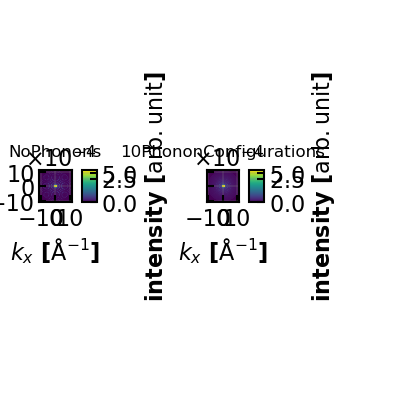

In [12]:
measurementsMean.show(power=0.3,cmap='viridis',cbar=True,explode=True)

[########################################] | 100% Completed | 7.28 sms


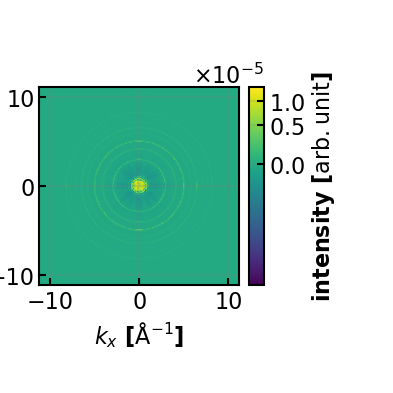

In [13]:
deviationMean = measurementsMean[0]-measurementsMean[1]
deviationMean.show(power=0.3,cmap='viridis',cbar=True,explode=True)

[########################################] | 100% Completed | 8.07 sms


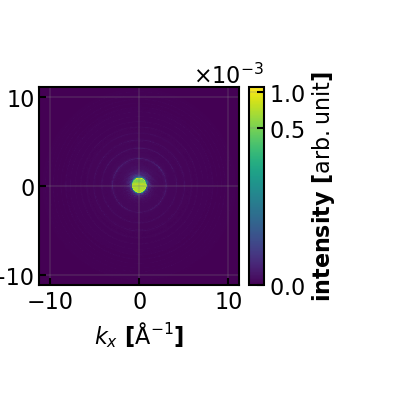

In [14]:
# PACBED single phonon configuration
measurements.mean((0,1)).show(power=0.3,cmap='viridis',cbar=True);

In [19]:
measurements.shape

(2, 28, 60, 494, 665)

In [18]:
measurements[1, 1].shape

(60, 494, 665)

In [ ]:
#visualize diffration pattern

cropped_diffraction_pattern = measurements[1, 1].crop(max_angle=180)

abtem.stack(
    [
        cropped_diffraction_pattern,
        cropped_diffraction_pattern.block_direct(),
    ],
    ("base", "block direct"),
).show(power=0.2,explode=True, cbar=True, figsize=(12, 6));

In [20]:
# HAADF preview

stacked = abtem.stack(
    [
        measurements.integrate_radial(0, 30),
        measurements.integrate_radial(75, 278),
        
    ],
    ("BF", "ADF"),
)

stacked.show(explode=True, cbar=True, figsize=(10, 10), cmap='gray', interact=True);
# plt.show()

[########################################] | 100% Completed | 17.30 s


ImageGUI(children=(VBox(children=(HBox(children=(Button(description='Reset sliders', style=ButtonStyle()), Tog…

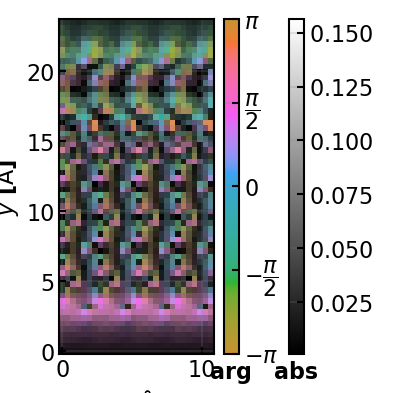

In [24]:
#check sampling with COM
center_of_mass = measurements.center_of_mass(units="1/Å")

# interpolated_center_of_mass = center_of_mass.interpolate(0.05)
# interpolated_center_of_mass = center_of_mass.interpolate(0.05).tile((10, 1))

center_of_mass.show(cbar=True);

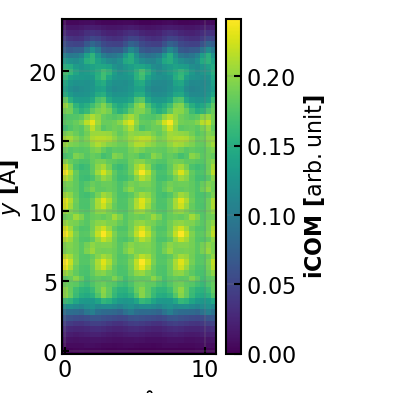

In [25]:
#
integrated_gradient = center_of_mass.integrate_gradient()

# interpolated_integrated_gradient = integrated_gradient.interpolate(0.05)

integrated_gradient.show(cbar=True);
plt.show()

In [ ]:
## remove vacuum from cell

# Get atomic positions
positions = GaS_on_sapphire.get_positions()

# Find minimum and maximum coordinates along each axis
min_pos = positions.min(axis=0)
max_pos = positions.max(axis=0)

# Compute the new cell dimensions (tight bounding box)
new_cell = max_pos - min_pos

# Shift atoms so the structure starts at origin
GaS_on_sapphire.translate(-min_pos)

# Update the cell
GaS_on_sapphire.set_cell(new_cell)
GaS_on_sapphire.set_pbc([True, True, True])  # Set periodic boundary conditions if needed

# plot 
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(6, 4))
abtem.show_atoms(GaS_on_sapphire, ax=ax1, title="xy Beam view", show_periodic=True, scale=0.5, legend=True)
abtem.show_atoms(GaS_on_sapphire, ax=ax2, plane="xz", title="Side view xz", show_periodic=True, scale=0.5,
                 legend=True)
abtem.show_atoms(GaS_on_sapphire, ax=ax3, plane="yz", title="Side view yz", show_periodic=True, scale=0.5,
                 legend=True)
fig.tight_layout()
fig.suptitle('GaS_on_sapphire full structure')

In [9]:
## Timing box GPU
abtem.config.set({"device": "gpu"})
lengths = GaS_on_sapphire.cell.lengths()
num_slices = 200

%timeit abtem.Potential(GaS_on_sapphire, sampling=0.15, parametrization="kirkland", slice_thickness=lengths[2]/num_slices, projection="infinite")



519 μs ± 11.3 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [10]:
## Timing box GPU
abtem.config.set({"device": "cpu"})
lengths = GaS_on_sapphire.cell.lengths()
num_slices = 200

%timeit abtem.Potential(GaS_on_sapphire, sampling=0.15, parametrization="kirkland", slice_thickness=lengths[2]/num_slices, projection="infinite")



398 μs ± 821 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
